# Toturial 1: Fine-tuning CellFM for Cell Type Annotation
In this tutorial, we will demonstrate how to fine-tune a pre-trained CellFM model to perform cell type annotation on a new single-cell dataset. The workflow consists of the following stages:

1. Data Preprocessing

2. Data Loading

3. Model construct

4. Weight Loading

5. Fine-tuning

6. Result Visualization

Before starting, import the following packages and set up the configuration:

In [1]:
import os
os.chdir("..")
print("Current working directory:", os.getcwd())

import scanpy as sc
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler
from layers.utils import *
import pandas as pd
import numpy as np
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

# from model import Cell_FM

cfg = Config_80M()
cfg.ecs_threshold = 0.8
cfg.ecs = True
cfg.add_zero = True
cfg.pad_zero = True
cfg.use_bs = 8
cfg.mask_ratio = 0.5
### Main param ###
cfg.dataset = "Pancrm4"
cfg.feature_col = "celltype"
cfg.ckpt_path = "/home/tl688/tl688/CellFM/checkpoints/CellFM_80M_weight.ckpt"
cfg.device = "cuda:2"
cfg.epoch = 5
cfg.num_cls = 1 # by default


Current working directory: /gpfs/gibbs/pi/zhao/tl688/CellFM/CellFM-torch


# Data Preprocessing

The data preprocessing workflow is identical to the original CellFM implementation. Please follow the same steps as described in the original [CellFM documentation](https://github.com/biomed-AI/CellFM/blob/main/tutorials/process.ipynb) to prepare your datasets.

# Load Data
Load an .h5ad single-cell dataset and return a PyTorch DataLoader ready for model training or testing.

In [2]:
def load_data(adata_path, mode="train"):
    adata = read_h5ad(adata_path)
    adata.obs['celltype'] = adata.obs['cell_type']
    adata.obs['feat'] = adata.obs[cfg.feature_col].cat.codes.values
    cfg.num_cls = len(adata.obs['feat'].unique())
    
    adata.obs['batch_id'] = 0
    if mode == "train":
        adata.obs['train'] = 0
        dataset = SCrna(adata, mode="train")
        prep = Prepare(cfg.nonz_len, pad=0, mask_ratio=cfg.mask_ratio)
        loader = build_dataset(
            dataset,
            prep=prep,
            batch_size=cfg.use_bs,
            pad_zero=cfg.pad_zero,
            drop=True,
            shuffle=True
        )
    if mode== "test":
        adata.obs['train'] = 2
        dataset = SCrna(adata, mode="test")
        prep = Prepare(cfg.nonz_len, pad=0, mask_ratio=cfg.mask_ratio)
        loader = build_dataset(
            dataset,
            prep=prep,
            batch_size=cfg.use_bs,
            drop=True,
            shuffle=True
        )
    return loader

# train_adata_path = f"/data/user/liwb/project/CellFM/datasets/cell_annotion/Inter/{cfg.dataset}/train.h5ad"
# test_adata_path = f"/data/user/liwb/project/CellFM/datasets/cell_annotion/Inter/{cfg.dataset}/test.h5ad"

# train_loader = load_data(train_adata_path, mode="train")
# test_loader = load_data(test_adata_path, mode="test")

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/data/user/liwb/project/CellFM/datasets/cell_annotion/Inter/Pancrm4/train.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Model construct
To make CellFM more flexible and reusable across different tasks, we retain its core masked recovery module and re-implement it in PyTorch as a class called `Cell_FM`. This class can either:

- Load a set of pre-trained weights and the corresponding configuration, or

- Be trained from scratch.

`Cell_FM` allows fine-tuning on new datasets to perform masked expression recovery and outputs a cls_token representing each cell.

For tasks that require cell type classification, we can simply add a linear classification layer on top of the cls_token. In this tutorial, we use a single hidden-layer linear model for this purpose.

Below, we demonstrate how to leverage the `Cell_FM` module to build a custom PyTorch model suitable for task-specific fine-tuning:

In [ ]:
class Finetune_Cell_FM(nn.Module):
    def __init__(self, cfg):
        super(Finetune_Cell_FM, self).__init__()
        self.cfg = cfg
        self.num_cls = cfg.num_cls
        self.extractor = Cell_FM(27855, self.cfg, ckpt_path=self.cfg.ckpt_path, device=self.cfg.device) # n_gene, cfg=config_80M()
        # notion: 27855 is the orignal pre_train gene set of 80M CellFM model
        self.cls = nn.Sequential(
            nn.Linear(self.cfg.enc_dims, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128, self.num_cls)
        )
    
    def forward(self, raw_nzdata,
                dw_nzdata,
                ST_feat,
                nonz_gene,
                mask_gene,
                zero_idx):
        
        mask_loss, cls_token = self.extractor(
                raw_nzdata,
                dw_nzdata,
                ST_feat,
                nonz_gene,
                mask_gene,
                zero_idx
            )
        
        cls = self.cls(cls_token)

        return cls, mask_loss, cls_token

# Weight Loading

You can easily load pre-trained weights using the `load_model` function in the `Cell_FM` module. Setting the option to False will initialize the model from scratch.

Note: During fine-tuning, we only unfreeze the `cls.` and `encoder` layers. This strategy reduces the computational cost and memory usage while still allowing effective adaptation to the new dataset.

In [ ]:
net = Finetune_Cell_FM(cfg) # 27855

for name, param in net.named_parameters():
    param.requires_grad = "cls." in name or "encoder" in name

print("Trainable parameters:")
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name)
net = net.to(cfg.device)
net.extractor.load_model(weight=True, moment=False)

optimizer = AdamW([p for p in net.parameters() if p.requires_grad], 
                    lr=1e-4,
                    weight_decay=1e-5)

scaler = GradScaler() 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

criterion_cls = nn.CrossEntropyLoss()


# Fine-tuning

In [ ]:
#### A lots of Path ####
PT_PATH = f"../data_pt/{cfg.dataset}"
MODEL_PATH = f"../model_checkpoint/{cfg.dataset}" # for 40000 cells

#### Make dir ####
os.makedirs(PT_PATH, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

#### save emb adata ####
def save_emb(emb, pred, label, save_path, mode):
    emb = np.vstack([np.atleast_2d(x) for x in emb])
    pred = np.concatenate([np.ravel(x) for x in pred])
    label = np.concatenate([np.ravel(x) for x in label])
    
    adata = sc.AnnData(
        X = emb,
        obs = pd.DataFrame({"pred": pred,
                          "label": label})
    )
    os.makedirs(save_path, exist_ok=True)
    sc.write(f"{save_path}/{mode}.h5ad", adata)

for epoch in range(cfg.epoch):
    train_emb, train_pred, train_label = [], [], []
    test_emb, test_pred, test_label = [], [], []
    net.train()
    print("training...")
    running_loss = 0.0
    running_acc = 0.0
    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{cfg.epoch}")
    
    for step, batch in enumerate(progress):    
        raw_nzdata = batch['raw_nzdata'].to(cfg.device)
        dw_nzdata = batch['dw_nzdata'].to(cfg.device)
        ST_feat = batch['ST_feat'].to(cfg.device)
        nonz_gene = batch['nonz_gene'].to(cfg.device)
        mask_gene = batch['mask_gene'].to(cfg.device)
        zero_idx = batch['zero_idx'].to(cfg.device)
        celltype_label = batch['celltype_label'].to(cfg.device)
        batch_id = batch['batch_id'].to(cfg.device)
        feat = batch['feat'].long().to(cfg.device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            cls, mask_loss, cls_token = net(
                raw_nzdata=raw_nzdata,
                dw_nzdata=dw_nzdata,
                ST_feat=ST_feat,
                nonz_gene=nonz_gene,
                mask_gene=mask_gene,
                zero_idx=zero_idx
            ) 
            
            cls_loss = criterion_cls(cls, feat)
            loss = mask_loss + cls_loss
        
        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        pred = cls.argmax(1)
        accuracy = (pred == feat).sum().item()
        accuracy = accuracy / len(batch_id)
        
        running_loss += loss.item()
        running_acc += accuracy
        
        avg_loss = running_loss / (step + 1)
        avg_acc = running_acc / (step + 1)
        
        progress.set_postfix(loss=avg_loss, acc=avg_acc)
        
        train_emb.append(cls_token.detach().cpu().numpy().tolist())
        train_label.append(feat.detach().cpu().numpy().tolist())
        train_pred.append(pred.detach().cpu().numpy().tolist())
    
    scheduler.step()
    print(f"Epoch {epoch+1} complete,avg loss: {avg_loss:.6f}")
    torch.save(net.state_dict(), f"{MODEL_PATH}/checkpoint_epoch_{epoch+1}.pth")
    
    # save adata train
    save_emb_pth = f"{PT_PATH}/epoch_{epoch}"
    save_emb(train_emb, train_label, train_pred, save_emb_pth, 'train')
    
    net.eval()
    print("testing...")
    running_loss = 0.0
    running_acc = 0.0

    progress = tqdm(test_loader, desc="Testing")
    with torch.no_grad(): 
        for step, batch in enumerate(progress):    
            
            raw_nzdata = batch['raw_nzdata'].to(cfg.device)
            dw_nzdata = batch['dw_nzdata'].to(cfg.device)
            ST_feat = batch['ST_feat'].to(cfg.device)
            nonz_gene = batch['nonz_gene'].to(cfg.device)
            mask_gene = batch['mask_gene'].to(cfg.device)
            zero_idx = batch['zero_idx'].to(cfg.device)
            celltype_label = batch['celltype_label'].to(cfg.device)
            batch_id = batch['batch_id'].to(cfg.device)
            feat = batch['feat'].long().to(cfg.device)

            with torch.cuda.amp.autocast():
                cls, mask_loss, cls_token = net(
                    raw_nzdata=raw_nzdata,
                    dw_nzdata=dw_nzdata,
                    ST_feat=ST_feat,
                    nonz_gene=nonz_gene,
                    mask_gene=mask_gene,
                    zero_idx=zero_idx
                ) 
                
                cls_loss = criterion_cls(cls, feat)
                loss = mask_loss[0] + cls_loss

            pred = cls.argmax(1)
            accuracy = (pred == feat).sum().item()
            accuracy = accuracy / len(batch_id)
            
            running_loss += loss.item()
            running_acc += accuracy
            
            avg_loss = running_loss / (step + 1)
            avg_acc = running_acc / (step + 1)
            
            progress.set_postfix(loss=avg_loss, acc=avg_acc)
            
            test_emb.append(cls_token.detach().cpu().numpy().tolist())
            test_label.append(feat.detach().cpu().numpy().tolist())
            test_pred.append(pred.detach().cpu().numpy().tolist())
    
    print(f"Testing {epoch+1} complete,avg loss: {avg_loss:.6f}, avg acc: {avg_acc:.6f}")
    
    # save adata test
    save_emb_pth = f"{PT_PATH}/epoch_{epoch}"
    save_emb(test_emb, test_label, test_pred, save_emb_pth, 'test')

training...


Epoch 1/5: 100%|██████████| 1132/1132 [04:16<00:00,  4.41it/s, acc=0.874, loss=12]  


Epoch 1 complete,avg loss: 11.991015
testing...


Testing: 100%|██████████| 186/186 [00:17<00:00, 10.57it/s, acc=0.972, loss=7.01]


Testing 1 complete,avg loss: 7.008198, avg acc: 0.971774
training...


Epoch 2/5: 100%|██████████| 1132/1132 [04:15<00:00,  4.43it/s, acc=0.942, loss=11.5]


Epoch 2 complete,avg loss: 11.498859
testing...


Testing: 100%|██████████| 186/186 [00:17<00:00, 10.39it/s, acc=0.97, loss=7.01] 


Testing 2 complete,avg loss: 7.013535, avg acc: 0.970430
training...


Epoch 3/5: 100%|██████████| 1132/1132 [04:14<00:00,  4.44it/s, acc=0.951, loss=11.5]


Epoch 3 complete,avg loss: 11.453113
testing...


Testing: 100%|██████████| 186/186 [00:17<00:00, 10.57it/s, acc=0.972, loss=7]   


Testing 3 complete,avg loss: 6.999070, avg acc: 0.971774
training...


Epoch 4/5: 100%|██████████| 1132/1132 [04:15<00:00,  4.42it/s, acc=0.958, loss=11.4]


Epoch 4 complete,avg loss: 11.404639
testing...


Testing: 100%|██████████| 186/186 [00:17<00:00, 10.56it/s, acc=0.983, loss=7]   


Testing 4 complete,avg loss: 6.996269, avg acc: 0.982527
training...


Epoch 5/5: 100%|██████████| 1132/1132 [04:15<00:00,  4.42it/s, acc=0.961, loss=11.4]


Epoch 5 complete,avg loss: 11.400399
testing...


Testing: 100%|██████████| 186/186 [00:17<00:00, 10.51it/s, acc=0.982, loss=6.99]


Testing 5 complete,avg loss: 6.987188, avg acc: 0.981855


# Result Visualization
During fine-tuning, we observed that the highest test PCC (0.982527) was achieved at the 4th epoch. To further evaluate the effectiveness of the model, we visualize the fine-tuned cell embeddings using UMAP, which provides an intuitive view of how well the embeddings capture the underlying cell type structure.

In [19]:
emb_train = sc.read("../data_pt/Pancrm4/epoch_4/train.h5ad")
emb_test = sc.read("../data_pt/Pancrm4/epoch_4/test.h5ad")

In [20]:
def plot_umap(adata):
    adata.obs["pred"] = adata.obs["pred"].astype('category')
    adata.obs["label"] = adata.obs["label"].astype('category')
    
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color="pred")
    sc.pl.umap(adata, color="label")

         Falling back to preprocessing with `sc.pp.pca` and default params.


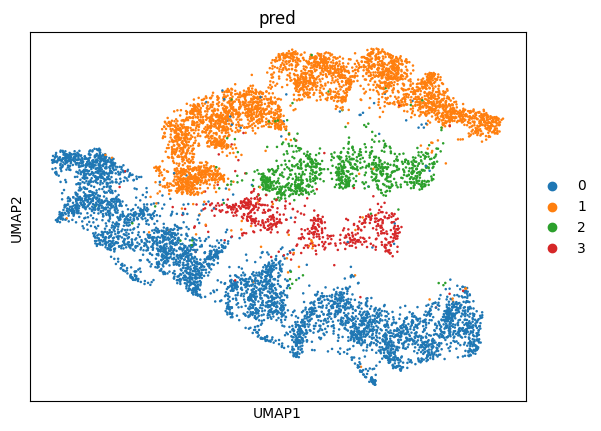

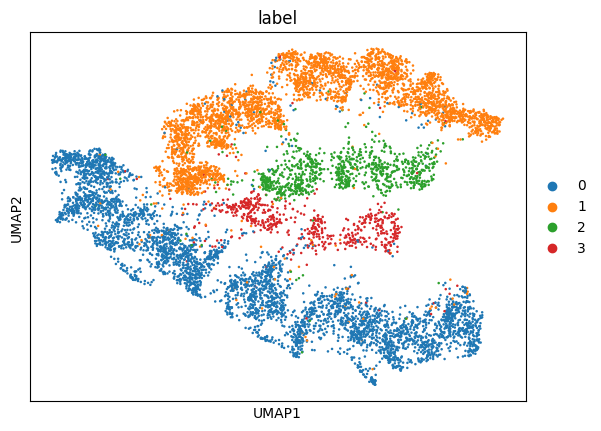

In [21]:
plot_umap(emb_train)

         Falling back to preprocessing with `sc.pp.pca` and default params.


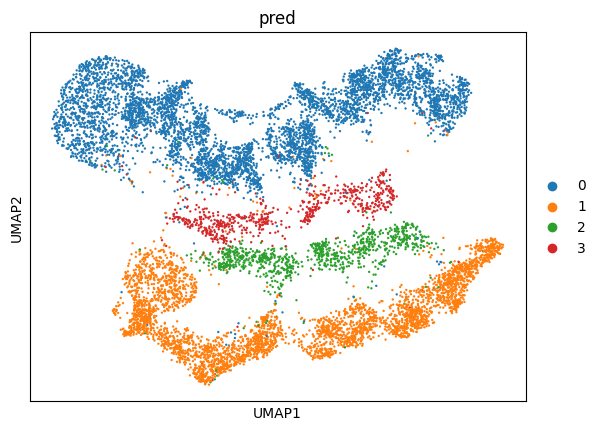

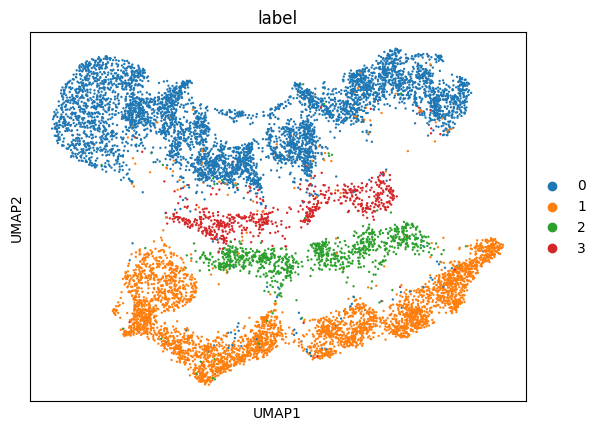

In [22]:
plot_umap(emb_test)